In [257]:
import torch
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from torch import nn

In [258]:
dataset = sns.load_dataset("flights")
dataset

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
...,...,...,...
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390


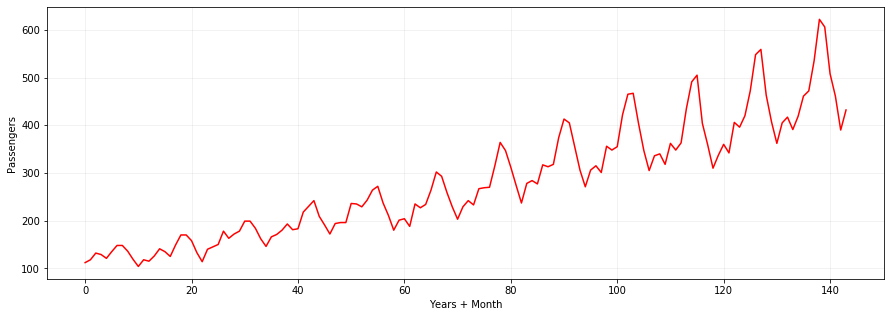

In [259]:
plt.figure(figsize=[15,5])
plt.grid(alpha=0.2), plt.xlabel("Years + Month"), plt.ylabel("Passengers")
plt.plot(list(dataset.index), dataset["passengers"], "r")

In [260]:
class data(Dataset):
    def __init__(self, df, window_length):
        original_dataset = df["passengers"].values.astype(np.double)
        self.dataset = []
        for i in range(len(original_dataset) - window_length):
            self.dataset.append(original_dataset[i:i + window_length])
            
        self.dataset = torch.from_numpy(np.stack(self.dataset, axis=0)).unsqueeze(-1)
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        return self.dataset[index], self.dataset[index+1][-1]
        

In [261]:
train_test_offset = 12
flight_dataset_train = data(dataset.iloc[:-train_test_offset], 12)
flight_dataset_test = dataset[-train_test_offset:]
train_loader = DataLoader(flight_dataset_train, batch_size=16)

In [262]:
# parameters:
iterations = 100
learning_rate = 0.001


In [263]:
# defining the model
class Model(nn.Module):
    def __init__(self, hidden_size=6):
        self.hidden_size = hidden_size
        super(Model, self).__init__()

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        
        
    def init_hidden(self, batch_size):
        return (torch.randn(1, batch_size, self.hidden_size).type(torch.float32), 
                torch.randn(1, batch_size, self.hidden_size).type(torch.float32))
    
    def forward(self, data):
        print(data)
        out, (_, _) = self.lstm(data, self.init_hidden(data.shape[0]))
        return self.linear(out[-1])

In [264]:
lstm_model = Model(12)
optim = torch.optim.Adam(lstm_model.parameters(), learning_rate)
MSE = torch.nn.MSELoss()

# training the model
for i in range(iterations):
    for x_batch, y_batch in train_loader:
        
        # Getting the possible outputs
        results = lstm_model(x_batch.s())
        
        # calculating the MSE loss
        loss = MSE(results, y_batch)
        
        # optimizing the model
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        
    print(f"iteration:{i}/{iterations},\tloss:{loss}")

AttributeError: 'Tensor' object has no attribute 's'

In [265]:
torch.nn.modules??